# Bericht Projektlabor Maschinelles Lernen (PML)

|Gruppenmitglied|Matrikelnummer|
|---|---|
|Christian Singer|2161064|
|Domenic Gosein|2160647|
|Lukas Burger|2150580|
|Maximilian Kürschner|2160331|

<p style="text-align: center;">Betreuender Dozent:<br>Dr.-Ing. Wei Yap Tan<br>Fakultät der Informationstechnik</p>
<p style="text-align: center;">Hochschule Mannheim<br>Wintersemester 2021/22</p>

## Inhalt

1. [Einleitung](#p1)
2. [Das Kalman Filter](#p2)
3. [1D Radarsensor Experiment](#p3)
    1. [Transitionmodell](#p31)
    2. [Übergangsmatrix/Messfunktion](#p32)  
    3. [Experimente](#p33)  
    4. [Metrik](#p341)
4. [3D Radarsensor Experiment](#p4)
    1. [3D Radarsensor Experiment ohne DBScan](#p41)
    2. [Verschiede Parameterwerte beim 3D Experiment](#p42)  
    3. [Der DBScan Algorithmus](#p43)  
    4. [3D Radarsensor Experiment mit DBScan](#p44)
5. [Interaktiver Teil (Jupyter Notebook)](#p5)
    1. [Interaktives Kalman Filter 1D](#p51)
    2. [Interaktiver DBScan](#p52)
    3. [Interaktiver Kalman Filter mit DBScan 3D](#p53)
6. [Schlussfolgerung und Ausblick](#p6)
7. [Verwendete Literatur](#p7)
8. [Anhang](#p8)
    1. [GitHub Workflow](#p81)
    2. [Jupyter Notebook](#p82)

*Wenn Sie diesen Bericht mit Juypter Notebook ausführen, müssen Sie als erstes folgende Zeilen ausführen, um alle nötigen Module zu importieren.*

In [1]:
# Import aller benötigten Module

# Eigene Module
import DataGenerationRadar1D as gen_1D
from DataGenerationRadar3D import *
from DBScan import *
from ui import interactive1DExperiment, interactiveDBScan, interactive3DExperiment

# Externe Module
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
from collections import deque
from ipywidgets import *
from collections import deque
%matplotlib widget

## Einleitung <a name="p1"></a>

Nach einer Einführung in maschinelles Lernen, war es unsere Aufgabe das Kalman Filter und den DBSCAN Algorithmus für Daten aus einem 1D und anschließend 3D Radarsensor zu implementieren.

Um ein besseres Verständis für das Kalman Filter zu erlangen, haben wir uns zunächst mit der Theorie dahinter beschäftigt. Im Zuge dieses Prozesses sind wir auf das $\alpha$-$\beta$-Filter gestoßen. Das $\alpha$-$\beta$-Filter bildet die Grundlage für eine Reihe von Filtern, darunter auch das Kalman 
Filter. Wir haben uns daher dazu entschlossen, dieses zu Übungszwecken zu implementieren.

In [2]:
class abFilter:
    def __init__(self, x_0, dx, a, b, dt):
        self.x_est = x_0 # initial state value
        self.dx = dx # inital change rate
        self.a = a # a scale factor
        self.b = b # b scale factor
        self.dt = dt # time step
    
    def step(self, values):
        ests = []
        preds = []
        for z in values:
            # Predict
            x_pred = self.x_est + (self.dx * self.dt)
            preds.append(x_pred)
            self.dx = self.dx
            # Update
            residual = z - x_pred
            self.dx += self.b * (residual)/self.dt
            self.x_est = x_pred + self.a * residual
            ests.append(self.x_est)
        return np.array(ests), np.array(preds)

In unserem Beispiel verwenden wir das Filter dazu, das Körpergewicht einer Person vorherzusagen.

Unser Filter verwendet dazu folgende Parameter:
* `x_0` als initialen Zusatandswert (in unserem Fall das Anfangsgewicht)
* `dx` als initiale Änderungsrate des Gewichts z. B. +0.5 kg/Tag
* `a` als Faktor für die Veränderung der Gewichtsmessung
* `b` als Faktor für die Änderungsrate des Gewichts
* `dt` für das Zeitintervall

sowie `values` für unsere Messwerte.

Nachdem das $\alpha$-$\beta$-Filter initialisiert wurde, führt es folgende Schritte aus:

1. Berechnung der Vorhersage im nächsten Zeitintervall basierend auf aktuellem Schätzwert, Änderungsrate und Zeitintervall
2. Berechnen der Differenz aus aktuellem Messwert und Vorhersage
3. Anpassung der neuen Änderungsrate mit Faktor `b`, des Restwerts aus Schritt 2 und dem Zeitintervall
4. Berechnung des neuen Schätzwerts mittels Vorhersage, Faktor `a` und Restwert

Um das Filter zu testen haben wir mittels einer Funktion 14 Messwerte generiert und diese an den Filter übergeben. Zur Initialisierung haben wir zudem 86 kg, einen Änderungsrate von +1 kg/Tag, einen $\alpha$-Wert von 0.4 und einen $\beta$-Wert von 0.2 und einen Zeitintervall von 1 übergeben. Auf passende Werte für `a` und `b` sind wir durch ausprobieren gestoßen.

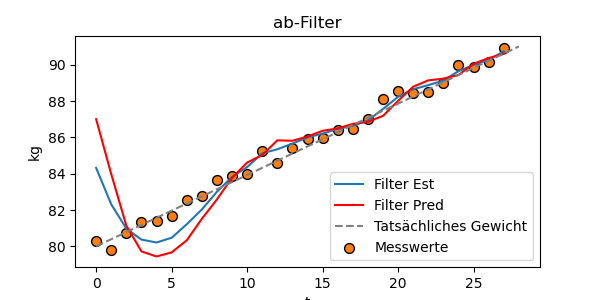

In [3]:
# Daten: Körpergewichte über n Tage verteilt gemessen
count = 28
def data_generator(x_0, dx, count, noise_factor):
    return [x_0 + dx * i + np.random.randn() * noise_factor for i in range(count)]

gewichte = data_generator(79.9, 0.4, count, 0.3) # kg
#print(gewichte)
zeitabstaende = [i for i in range(28)] # n Tage
print()
# Initialisierung und Ausführung des ab-Filters
gewicht_filter = abFilter(x_0=86, dx=1, a=0.4, b=0.2, dt=1.)
pr = gewicht_filter.step(values=gewichte)

# Ploten der Filter Ergebnisse im Vergleich zu den den echten Werten
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(pr[0], label='Filter Est')
ax.plot(pr[1], label='Filter Pred', color='r')
ax.scatter(zeitabstaende, gewichte, s=50, facecolor='C1', edgecolor='k', label='Messwerte')
ax.plot([0,count], [80., 91.], label='Tatsächliches Gewicht', linestyle='--', color='grey')
ax.set_xlabel('t')
ax.set_ylabel('kg')
ax.set_title("ab-Filter")
ax.legend()

Die von uns gewählte initiale Schätzung von 86 kg war mit Absicht sehr hoch gewählt. Wir sehen daher einen großen Ausschlag zu Beginn, schließlich benötigt das Filter einige Iterationen, um sein Werte anzupassen, so dass das Filter zum Ende hin eine deutlich bessere Schätzung ausgibt. 

Im nächsten Kapitel widmen wir uns nun dem Kalman Filter.

## Das Kalman Filter <a name="p2"></a>

Das Kalman Filter ist ein Algorithmus, der anhand einer Reihe von Messungen über eine gewisse Zeit unbekannte Variablenwerte eines Systems schätzt. Dabei versucht das Filter Unsicherheiten, die z. B. durch den Luftwiderstand entstehen, durch statistisches Rauschen und den Einbezug eines zu Grunde liegenden physiklasichen Modells zu reduzieren.

In unserem Fall versuchen wir mit das Kalman Filter die Position eines Objekts erst im eindimensionalen Raum, dann in einem dreidimensionalen Raum vorherzusagen. Die dafür notwendigen Messwerte liefert uns dabei eine Radarsensor Simulation.

Die Klasse `KalmanFilter` implementiert das Kalman Filter und besteht aus zwei Methoden. Über die `__init__(self, s_hat, transition_model, H, Q, R)` Methode kann das Kalman Filter mit folgenden Parametern initialisiert werden:
* `s_hat`: Position des Objekts, also x bzw. x, y und z Koordiante(n)
* `P_hat`: Kovarianz des Zustands
* `transition_model`: zu Grunde liegenes physikalisches Modell
* `H`: Messfunktion
* `Q`: Prozessrauschen
* `R`: Messrauschen

Nach der Initialisierung kann die `step(self,z)` Funktion mit den Messwerten `z` aufgerufen werden, um den zuvor initialisierten Kalman Filter Algorithmus auszuführen.

In [4]:
class KalmanFilter:
    # Initialisierung von Kalman Filter
    def __init__(self, s_hat, transition_model, H, Q, R):
        self.s_hat = s_hat
        self.P_hat = np.eye(len(s_hat)) * 100
        self.model = transition_model
        self.H = H # Measurement Function
        self.Q = Q # Process Noise
        self.R = R # Measurement Noise
    
    # Kalman Filter Algorithmus
    def step(self, z):
        # Prediction
        s_hat_p = self.model @ self.s_hat
        P_hat_p = self.model @ self.P_hat @ self.model.T + self.Q
        # Calculate Kalman Gain
        K = P_hat_p @ self.H.T @ np.linalg.inv(self.H @ P_hat_p @ self.H.T + self.R)
        # Update covariance of estimation error
        # self.P_hat = self.P_hat - K @ self.H @ self.P_hat
        self.P_hat = (np.eye(len(self.s_hat)) - K @ self.H) @ P_hat_p
        # Improve estimate
        e_m_p = z - self.H @ s_hat_p
        self.s_hat = s_hat_p + K @ e_m_p
        return self.s_hat

Im Detail führt die `step(self,z)` Methode dann folgende Schritte nacheinander aus:

1. Vorhersage der neuen Position
2. Berechnung der Kovarianz des Zustands
3. Berechung des Kalman Gain
4. Aktualisierung der Kovarianz des Zustands 
5. Verbesserung der Schätzung und Rückgabe der neuen Position

Der dabei entstehende Kalman Gain `K`, gibt an, wie sehr wir der Vorhersage im Vergleich zur Messung vertrauen. Im Gegensatz zum $\alpha$-$\beta$ Filter wird beim Kalman Filter also mithilfe von `K` der Einfluss der Sensormessung und der Vorhersage des Models auf die Vorhersage des Filters dynamisch reguliert.

## 1D Radarsensor Experiment <a name="p3"></a>

Die Simulation für den 1D Radarsensor gibt uns Messzustände vom **Abstand** und **Geschwindigkeit** eines Objektes zum Radarsendor und biete die Möglichkeit zwischen fünf verschiedenen Bewegungsarten zu wählen: *Static*, *Constant Velocity*, *Constant Acceleration*, *Sinus* und *Triangle*. Zusätzlich lassen sich folgende Sensor Eigenschaften für die Experimente anspassen (Default-Wert in Klammern):

* "initialDistance": Start Position des Objektes ($8 m$),
* "stopTime": Messzeit des Sensors ($1 s$),
* "SporadicError": Anzahl der Außreißer ($5$),
* "initialVelocity": Start Geschwindigkeit des Objektes ($3 m/s$)
* "movementRange": Amplitude der Sinus/Trianglebewegung ($1$),
* "frequency": Periode der Sinus/Trianglebeweung ($2$),
* "velocity": Konstate Geschwindigkeit ($3 m/s$)
* "acceleration": Konstatne Beschleunigung ($3 m/s^2$)

### Transitionmodell <a name="p31"></a>

Der Radasenor misst die Posistion und die Geschwindikeit eines Objektes mit einer gegebenen Taktfrequenz, welches zu Modellierung des Weg-Zeit-Gesetzes geführt hat:

* Beschleunigung: $a = const$
* Geschwingkeits-Zeit-Gesetzt: $v(t) = \dot{s}(t) = at + v_0$
* Weg-Zeit Gesetz: $s(t) = \frac{a}{2}t^2 + v_0t +s_0$

Für die Anwendung des Modells muss die Messgeschwindkeit des Sensors berücksichtig werden, wodurch der Zeitschritt($dt$) sich wie folgt berechnenen lässt:

\begin{equation}
dt = \frac{1}{ Taktfrequenz}
\end{equation}

Bei einer Taktfrequenz von  $100 Hz$ führt dies zu folgendem Transitionsmodell:

In [5]:
dt = 1 / gen_1D.measurementRate # 100 Hz
transition_model = np.array([[1, dt, dt**2 /2],
                            [0, 1,    dt  ],
                            [0, 0,    dt ]])
transition_model

array([[1.e+00, 1.e-02, 5.e-05],
       [0.e+00, 1.e+00, 1.e-02],
       [0.e+00, 0.e+00, 1.e-02]])

### Übergangsmatrix/Messfunktion <a name="p32"></a>

Um die im Kalmanfilter geschätzen Werte mit den Messwerten vergleichen zu können, muss die Messfunktion auf

* Postion
* Geschwindigkeit 

begrenzt werden. Hierbei entsteht folgende Übergangsmatrix:

In [6]:
H = np.array([[1., 0., 0.],
             [0., 1., 0.]])
H

array([[1., 0., 0.],
       [0., 1., 0.]])

### Experimente <a name="p33"></a>

Im folgenden wird der Code für ein Experiment, anhand der Bewegungsart *Static*, erklärt. Für die darauf folgenden Bewegungsarten werden anschließend statische Bilder aus dem Unterorder *figs* geladen und erläutern. Diese können im interaktiven Teil des 1D-Radarsensor nachtgestellt werden.

### Static <a name="p34"></a>

Zuerst wird der Radarsensor mit dem Default-Werten initalisiert und die gewünschte Bewegungsart ausgewählt.

In [7]:
opt = {
    "initialDistance": 8,
    "stopTime": 1,
    "SporadicError": 5,
}
timeAxis, distValues, velValues, truthDistValues, truthVelValues = gen_1D.GenerateData(type="Static", options=opt)

Anschließend wird das Messrauschen $R$ ermittelt. Diese errechnet sich aus der Sensorgenauigkeit, die durch die Standardabweichung des Messwerts vom wahren Wert(während einer Kalibrierung) dargestellt wird. Dabei kann die Sensorgenauigkeit entweder beim Hersteller erfragt oder durch eigene Messreihen einer statischen Szenen, wie folgt geschätzt werden:

In [8]:
# Sensor ohne vereinzelne Fehler
opt_zero_err = {
    "initialDistance": 8,
    "stopTime": 1,
    "SporadicError": 0,
}
# Führe x-Messreihen durch und nehme die Varianz in den Daten auf
dist_mesurment_err = list()
vel_mesurment_err = list()
for i in range(1000):
    gen_1D.seed = i
    _, distValues_test, velValues_test, _, _ = gen_1D.GenerateData(type="Static",
                                                                    options=opt_zero_err)
    dist_mesurment_err.append(np.var(distValues_test))
    vel_mesurment_err.append(np.var(velValues_test))
pos_var = np.mean(dist_mesurment_err)
vel_var = np.mean(vel_mesurment_err)
print(f"Positions-Genauigkeit: +-{pos_var} m")
print(f"Geschwindigkeits-Genauigkeit: +-{vel_var} m/s")

Positions-Genauigkeit: +-0.0001318894150845477 m
Geschwindigkeits-Genauigkeit: +-8.243652403552338e-06 m/s


Somit kann $R$ initalisiert werden:

In [9]:
R = np.diag([pos_var,vel_var])
R

array([[1.31889415e-04, 0.00000000e+00],
       [0.00000000e+00, 8.24365240e-06]])

Da auch das physikalische Modell für die Zustandermittlung des Objektes gestört werden kann, wird hierfür das Prozessrauschschen $Q$ verwendet. Diese ist stark von dem zugrunde liegenden Transitionmodell und seiner genauen physikalischen Beschreibung abhäning. <br>
Je höher $Q$, desto mehr Gewicht haben die verrauschten Messungen und die Schätzgenauigkeit wird beeinträchtigt. Im Falle eines niedrigeren $Q$ wird eine bessere Schätzgenauigkeit erreicht und zeitliche Verzögerungen in den Messwerten können besser tolleriert werden.

Bei einem nicht rellen Problemn kann davon ausgegangen werden, dass $Q$ eine Nullmatrix ist. Jedoch hilft eine $Q$-Matrix von Null verschiedenen bessere Konvergenzeigenschaften zu erhalten.

In [10]:
Q = np.diag([0, 0, 0])
Q

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

Am Ende müssen noch die Startzustände $s_0$ des Kalman-Filter initalisiert werden. Diese können entweder mit hohen/niedrigen Werten gesetzte werden, welches einen Einfluss auf die Konvergenz der Kalaman-Verstärkung mit sich führt oder den Messdaten wird mehr vertrauen geschenkt, sodass die ersten Messerwerten als Initalisierung des Kalman-Filters verwendet werden können.

In [11]:
s0 = np.array([distValues[0], velValues[0], 0]) # initalisierung der Startwerte mit ersten Messwerten
s0

array([ 7.99498160e+00, -1.26359182e-03,  0.00000000e+00])

Nun kann der Kalman-Filter auf den Messdaten verwendet werden und die korregierten Messungen werden in `Predictions` zwischengespeichert.

In [12]:
kalmanFilter1D = KalmanFilter(s0, transition_model, H, Q, R)
Predictions = [s0]
for i in range(1, np.size(timeAxis)):
    s = np.array([distValues[i], velValues[i]])
    pred = kalmanFilter1D.step(s)
    Predictions.append(pred)

Zur **Visualisierung** des 1D Kalman-Filters werden jeweils zwei Grafiken mit der Postion und Geschwindigkeit gezeigt:
* Blaue Line: Zustand (Ground Truth)
* Rote Punkte: Messwerte
* Grüne Puntke: Geschätze Werte

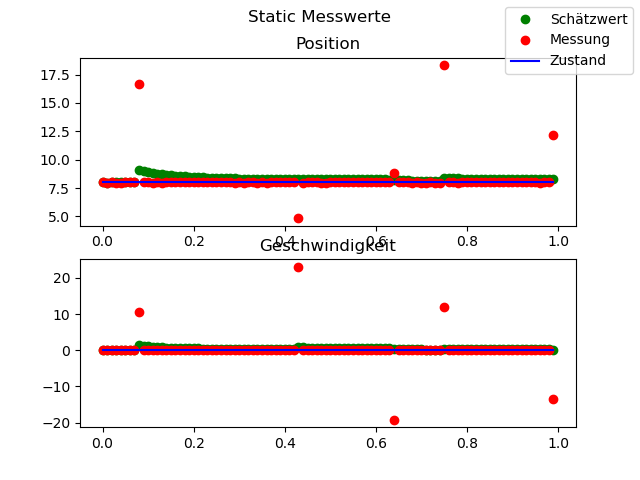

In [13]:
fig, axs = plt.subplots(2)
fig.suptitle('Static Messwerte')
Predictions = np.array(Predictions)

axs[0].set_title('Position')
axs[1].set_title('Geschwindigkeit')
kalman_1D_dist, = axs[0].plot(timeAxis, Predictions[:, 0], 'go',label="Schätzwert")
kalman_1D_vel, = axs[1].plot(timeAxis, Predictions[:, 1], 'go')
data_dist, = axs[0].plot(timeAxis, distValues, 'ro',label="Messung")
data_vel, = axs[1].plot(timeAxis, velValues, 'ro')
true_dist, = axs[0].plot(timeAxis, truthDistValues, 'b',label="Zustand")
true_vel, = axs[1].plot(timeAxis, truthVelValues, 'b')
fig.legend()

**Metrik** <a name="p341"></a>

Zur besseren Verständnis und Überblick haben wir den Mean-Square-Error (MSE) zwischen den vom Kalmanfilter geschätzten Werten ($pred$) und den Messwerten($meas$) zu der Ground Truth($GT$) berechnet.

$$
mse_{pred} = \frac{1}{n} \sum_{1}^{n}(pred - GT)^2
$$

$$
mse_{meas} = \frac{1}{n} \sum_{1}^{n}(meas - GT)^2
$$

Um eine Verbesserung bzw. Verschlechterung der geschätzten Werten nachvollziehen zu können, wurde anschließend das Verhätlniss zwischen den $mse_{pred}$ zu $mse_{meas}$ berechnet:

$$
1- \frac{mse_{pred}}{mse_{meas}}
$$

Somit erreichen wir im vorherigen Experiment folgende Metriken:

In [41]:
pos_pred,pos_sens,pos_ratio =  gen_1D.compute_mse(Predictions[:, 0], truthDistValues, distValues)
vel_pred,vel_sens,vel_ratio =  gen_1D.compute_mse(Predictions[:, 1], truthVelValues, velValues)
print(f"MSE der Messwerten : \t Pos: {pos_sens:>10.5f}  \t Vel: {vel_sens:>10.5f}")
print(f"MSE der Schätzwerte: \t Pos: {pos_pred:>10.5f}  \t Vel: {vel_pred:>10.5f}")
print(f"Verbesserung       : \t Pos: {pos_ratio:>10.5f} \t Vel: {vel_ratio:>10.5f}")

MSE der Messwerten : 	 Pos:    2.10459  	 Vel:   13.33246
MSE der Schätzwerte: 	 Pos:    0.14025  	 Vel:    0.23639
Verbesserung       : 	 Pos:    0.93336 	 Vel:    0.98227


Ist nun die Anzahl der zufällig erschneinten **Fehler sehr hoch**(50), sind die Messwerten nicht mehr zuverlässig und das Prozessrauschen muss im Kalman-Filter neu angepasst werden.

$$
Q = 
\begin{pmatrix}
0.00001 & 0 & 0 \\
0 & 0.00005 & 0 \\
0 & 0 & 0.0005 \\
\end{pmatrix}
$$

$$
R = 
\begin{pmatrix}
0.0279 & 0 \\
0 & 0.103 \\
\end{pmatrix}
$$

![](figs/Static_with_high_err.png)

In der Grafik kann gut erkannt werden, dass das Kalman-Filter gegeüber dem starken Prozessrauschen lernt(siehe ab 0.6 Sekunde der Geschwindigkeit) und gute Vohersagen treffen kann, welches sich in den folgenden Metriken auch wiederspiegelt:

$$
\begin{aligned}
&\begin{array}{ccc}
& Position & Geschwindigkeit \\
\hline
MSE_{Messwerten}  &   30.78603 &  74.18581\\
MSE_{Schätzwerte}&   2.98777  &   2.10236 \\
Verbesserung        &   0.90295  &   0.97166 \\
\end{array}
\end{aligned}
$$

### Constant Velocity <a name="p35"></a>


$$
Q = 
\begin{pmatrix}
0.00001 & 0 & 0 \\
0 & 0.00005 & 0 \\
0 & 0 & 0.0005 \\
\end{pmatrix}
$$

$$
R = 
\begin{pmatrix}
0.0279 & 0 \\
0 & 0.103 \\
\end{pmatrix}
$$

![](figs/Const_Vel.png)


$$
\begin{aligned}
&\begin{array}{ccc}
& Position & Geschwindigkeit \\
\hline
MSE_{Messwerten}  &   30.78603 &  74.18581\\
MSE_{Schätzwerte}&   2.98777  &   2.10236 \\
Verbesserung        &   0.90295  &   0.97166 \\
\end{array}
\end{aligned}
$$

### Constant Acceleration <a name="p36"></a>

$$
Q = 
\begin{pmatrix}
0.00001 & 0 & 0 \\
0 & 0.00005 & 0 \\
0 & 0 & 0.0005 \\
\end{pmatrix}
$$

$$
R = 
\begin{pmatrix}
0.0279 & 0 \\
0 & 0.103 \\
\end{pmatrix}
$$

![](figs/Const_Acc.png)


$$
\begin{aligned}
&\begin{array}{ccc}
& Position & Geschwindigkeit \\
\hline
MSE_{Messwerten}  &   30.78603 &  74.18581\\
MSE_{Schätzwerte}&   2.98777  &   2.10236 \\
Verbesserung        &   0.90295  &   0.97166 \\
\end{array}
\end{aligned}
$$

### Sinus <a name="p37"></a>

$$
Q = 
\begin{pmatrix}
0.00001 & 0 & 0 \\
0 & 0.00005 & 0 \\
0 & 0 & 0.0005 \\
\end{pmatrix}
$$

$$
R = 
\begin{pmatrix}
0.0279 & 0 \\
0 & 0.103 \\
\end{pmatrix}
$$

![](figs/Sinus.png)


$$
\begin{aligned}
&\begin{array}{ccc}
& Position & Geschwindigkeit \\
\hline
MSE_{Messwerten}  &   30.78603 &  74.18581\\
MSE_{Schätzwerte}&   2.98777  &   2.10236 \\
Verbesserung        &   0.90295  &   0.97166 \\
\end{array}
\end{aligned}
$$

### Triangle <a name="p38"></a>

$$
Q = 
\begin{pmatrix}
0.00001 & 0 & 0 \\
0 & 0.00005 & 0 \\
0 & 0 & 0.0005 \\
\end{pmatrix}
$$

$$
R = 
\begin{pmatrix}
0.0279 & 0 \\
0 & 0.103 \\
\end{pmatrix}
$$

![](figs/Triangle.png)


$$
\begin{aligned}
&\begin{array}{ccc}
& Position & Geschwindigkeit \\
\hline
MSE_{Messwerten}  &   30.78603 &  74.18581\\
MSE_{Schätzwerte}&   2.98777  &   2.10236 \\
Verbesserung        &   0.90295  &   0.97166 \\
\end{array}
\end{aligned}
$$

## 3D Radarsensor Experiment <a name="p4"></a>

Um die Ergebnisse und den Vorteil des DBScan Algorithmus zu verdeutlichen, haben wir das Experiment in zwei Abschnitte unterteilt. Im ersten Abschnitt betrachten wir die unterschiedlichen Ergebnisse des Experiments nur mit das Kalman Filter, im zweiten Abschnitt dann mit vorgelagertem DBScan Algorithmus.

### 3D Radarsensor Experiment ohne DBScan <a name="p41"></a>

Zu Beginn wissen wir noch nicht, welche Werte für den 3D Fall gut geeigenet sind. Wir initialisieren den ersten Kalman Filter deshalb mit uns plausiblen Werten und führen in damit aus.

Unser **Übergangsmodell** basiert auf dem im Skript gegebenen pysikalischen Model der gleichmäßig beschleunigten Bewegung mit drei Parametern:
* Beschleunigung
* Geschwindigkeit
* Position

Bei einer *measurementRate* von *100 Hz* sieht dass zugrunde liegende Gleichungsystem demnach wie folgt aus:

$$
\begin{pmatrix}
1 & 0.01 & 0.01/2 \\
0 & 1 & 0.01 \\
0 & 0 & 0.01 \\
\end{pmatrix}
$$


In [15]:
transition_model = np.array([[1, 0.01, 0.01/2],
                             [0, 1,    0.01  ],
                             [0, 0,    0.01 ]])
print(transition_model)

[[1.    0.01  0.005]
 [0.    1.    0.01 ]
 [0.    0.    0.01 ]]


Die **Q-Matrix** und damit unser Prozessrauschen setzen wir zunächst auf einen sehr kleinen Wert `0.02` für alle drei Parameter. Damit wollen wir erreichen, dass der Filter unserem Modell mehr vertraut als den Messungen.

$$
\begin{pmatrix}
0.02 & 0 & 0 \\
0 & 0.02 & 0 \\
0 & 0 & 0.02 \\
\end{pmatrix}
$$

In [16]:
Q = np.diag([0.002, 0.002, 0.002])
print(Q)

[[0.002 0.    0.   ]
 [0.    0.002 0.   ]
 [0.    0.    0.002]]


Die **R-Matrix** initialisieren wir mit folgendem Wert, wobei ${\sigma} = rangeAccuracy$, für das Messrauschen des Radarsensor:

$$
\frac{\sigma^2}{3}
$$

Wir wählen diesen Wert, da die Fehler des Sensors uniform verteilt sind und die Varianz einer uniform verteilten Zufallsvariable sich wie folgt berechnen lässt:

Sei $x\sim U[a,b]$, dann gilt $\text{Var}(x)=\frac{1}{12}\cdot(b-a)^2$ da in unserem Falle $b=\sigma$ und $a=-\sigma$ ergibt sich die oben abgebildete Formel.

In [17]:
R = np.diag([rangeAccuracy**2])/3
#R = np.diag([0.001])  # --> Zeile später entfernen!
print(R)

[[0.00083333]]


Zum Schluss initialisieren wir die **H-Matrix** wie folgt, so dass sie (alle drei) Parameter berücksichtigt:

$$
\begin{pmatrix}
1 & 0 & 0 \\
\end{pmatrix}
$$

In [18]:
H =  np.array([[1, 0, 0]])
print(H)

[[1 0 0]]


Die Einstellungen für unser *Target* belassen wir bei den uns gegebenen Werten:

In [19]:
path = [[0,5,0],
        [0,5,0.5],
        [1,5,1],
        [1,5,0.5],
        [0.5, 2, 0.1]]

vel = 3 * numpy.ones((1,5))
vel[0,2] = 1

InitialPosition = numpy.array([-1,5,0])

opt = {
    'InitialPosition' : InitialPosition,
    'Path' : numpy.array(path).transpose(),
    'Velocities' : vel
}

x = Target(opt)

targets = [x]

Lediglich bei den Einstellungen des Radarsensors nehmen wir eine kleine Anpassungen vor. Uum die *False Detections* zu reduzieren, haben wir einen zusätzlichen Parameter zu den Optionen des 3D Radarsensors hinzugefügt. Der neue Parameter `falseDetectionsRange` bestimmt die *Range* der *False Detections* im *DataGenerationRadar3D* Skript.

In [20]:
optRadar = {
    'Position' : numpy.array([0,0,0.5]),
    'OpeningAngle' : numpy.array([120,90]), # [Horizontal, Vertical]
    'FalseDetection': True,
    'falseDetectionsRange' : 10 # neuer Parameter für Range
}
sensor = RadarSensor(optRadar)

Anschließend iterieren wir mit nachfolgender Schleife über die *Detections* des 3D Radarsensors und plotten das Ergebnis:

In [21]:
# Initialisierung benötigter Variablen
Detections = np.array([0,0,0,0])
i = 0
pred = []

getNext = True
while(getNext == True):
    
    for target in targets:
        target.Step(1/sensor.opt['MeasurementRate'])
        getNext = getNext & ~target.reachedEnd  

    dets = sensor.Detect(targets)
    for det in dets:
        Detections = np.vstack((det, Detections))
    
    s0 = np.vstack((Detections[0,:-1], np.zeros((2,3))))
    
    if i == 0:
        f = KalmanFilter(s0, transition_model, H, Q, R)
        pred.append(s0[0,:])
    
    s = Detections[0,:-1].reshape(1,3)
    s_hat = f.step(s)
    pred = np.vstack((s_hat[0,:], pred))
    i += 1

In den beiden Abbildungen sehen wir die *Predictions* des Kalman Filter getrennt von den *Detections* der Simulation:

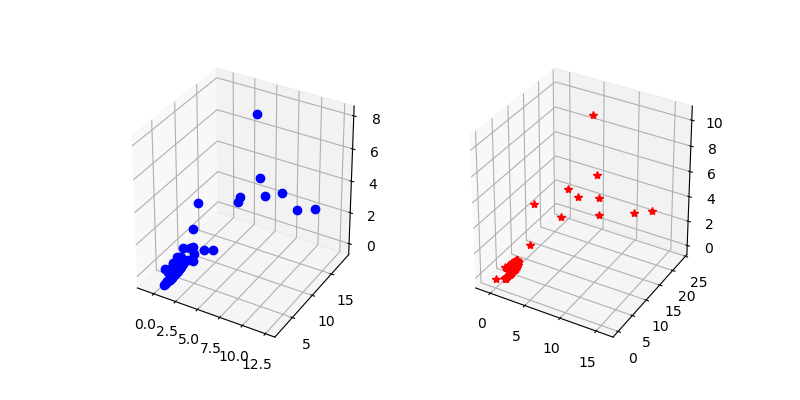

In [22]:
T1 = pred[:-1]

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121, projection='3d')   
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot3D(T1[:,0], T1[:,1], T1[:,2], 'bo')
ax2.plot3D(Detections[:,0], Detections[:,1], Detections[:,2], 'r*')

Legen wir beide zusammen erhalten wir folgenen Plot:

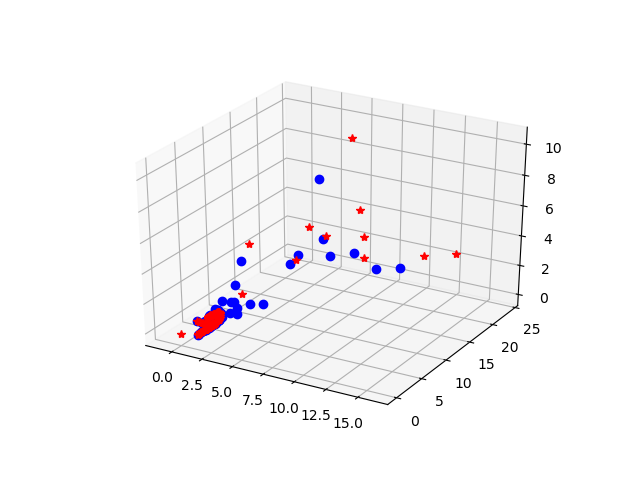

In [23]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(T1[:,0], T1[:,1], T1[:,2], 'bo')
ax.plot3D(Detections[:,0], Detections[:,1], Detections[:,2], 'r*')

In diesem zusammengefügten Plot können wir nun deutlich erkennen wir gut oder schlecht unser Kalman Filter mit seiner aktuellen Initialisierung die Posistion unseres Objekts vorhersagt. Je näher die blauen Punkte des Kalman Filters am Pfad liegen, desto besser funktioniert die initialisierte **Q-/R-Matrix**.

Im folgenden werden wir die einzelnen Parameter des Kalman Filter verändern und das Ergebnis dabei untersuchen, bis wir eine überzeugende Einstellung gefunden haben.

### Verschiede Parameterwerte beim 3D Experiment <a name="p42"></a>

Als estes verändern wir die **Q-Matrix**. Indem wir deren Werte erhöhen und damit mehr Rauschen zum Prozess hinzufügen.

```python
Q = np.diag([0.5, 0.5, 0.5])
```

![](figs/QMatrix-05-fig1.png)
![](figs/QMatrix-05-fig2.png)

Wie man sehen kann, führt dies dazu, dass die blauen Punkte des Filters nahe an den roten Sternen des Radarsensors liegen, diese Einstellung für die **Q-Matrix** eignet sich also nicht besonders gut, da sie den Messungen ein zu großes Vertrauen schenkt.

Belassen wir nun die **Q-Matrix** bei einem Wert von `0.02` und erhöhen den Wert der **R-Matrix** auf `0.05`, sehen wir, dass die Vorhersagen des Filters bevorzugt werden. Wir sehen also sehr deutlich, dass die blauen Punkte des Filters nah am Pfad und weit von den Messungen des Sensors liegen. Dennoch ist die Einstellung nicht optimal, da sie zu großen Abweichungen vom Pfad führt.

```python
Q = np.diag([0.02, 0.02, 0.02])
R = np.diag([0.05])
```

![](figs/RMatrix-005-fig1.png)
![](figs/RMatrix-005-fig2.png)

Was ist nun die optimale Einstellung?

TEXT UND BILDER EINFÜGEN

### Der DBScan Algorithmus <a name="p43"></a>

Der DBSCAN Algorithmus findet vorhande Cluster in einer Menge an Datenpunkten. Um diese Aufgabe zu erfüllen hat der Algorithmus zwei verstellbare Parameter. Zum einen den Paramater `eps`, der bestimmt in welchem Radius um den Datenpunkt nach Nachbarn gesucht wird, und zum anderen den Parameter `minpts`, der festlegt wie viele Punkte es minimal braucht damit es sich um einen Kernobjekt handelt, um welches man ein Cluster aufbauen kann.
Da sich die gefunden Cluster mit dem verstellen der Parameter ändern können müssen diese auf das jeweilige Problem angepasst werden.

Für den DBSCAN wurde eine Klasse erstellt, durch die der Algorithmus mit den beiden zuvor geannten Parametern initialisiert wird. Einmal initialisiert kann man den Algorithmus mit den gesetzten Parametern auf verschiedene Datensätze anwenden.

In [24]:
class DBSCAN():
    def __init__(self, eps=0.5, minpts=5):
        self.eps = eps
        self.minpts = minpts

Um die Cluster in einem bestimmten Datensatz zu finden besitzt die DBSCAN Klasse die Funktion `fit(self, X)`. Dabei entspricht `X` dem Datensatz der analysiert werden soll. Innerhalb dieser Funktion wird der DBSCAN Algorithmus auf die Daten aus `X` angewendet und die einzelnen Datenpunkte werden als Kernobjekte, Dichte-erreichbare Objekte und Rauschpunkte kategorisiert.\
Für die Bestimmung der Punkte Art wird der Abstand zwischen zwei Punkten benötigt. Um diesen Abstand zu bestimmen wird die Hilfsfunktion `pairwise_sq_distance` erstellt.

In [25]:
def pairwise_sq_distance(X1, X2):
    # Calculate the pairwise distance between all pairs of points from X1 and X2.
    return np.sum(X1**2, axis=1, keepdims=True) - 2*np.matmul(X1, X2.T) + np.sum(X2**2, axis=1, keepdims=True).T

In [26]:
def fit(self, X):
    dist = pairwise_sq_distance(X, X)
    neighbours = list(map(lambda d: np.arange(d.shape[0])[d < self.eps**2], dist))
    
    # Label all points as outliers initially.
    self.assignment = np.full((X.shape[0],), -1, dtype=int)
    # Find core points.
    # Determine the number of neighbors of each point.
    N_neighbors = np.sum(dist < self.eps**2, axis=1)
    self.assignment[N_neighbors >= self.minpts] = -2
    
    # Create clusters.
    cluster = 0
    stack = deque()
    for p in range(X.shape[0]):
        if self.assignment[p] != -2:
            continue
            
        self.assignment[p] = cluster
        
        stack.extend(neighbours[p])
        # Expand cluster outwards. 
        while len(stack) > 0:
            n = stack.pop()
            label = self.assignment[n]
            # If core point include all points in ε-neighborhood.
            if label == -2:
                stack.extend(neighbours[n])
            # If not core point (edge of cluster).
            if label < 0:
                self.assignment[n] = cluster
        
        cluster += 1

DBSCAN.fit = fit

Die Funktion `fit` findet die verschiedenen Cluster und speichert diese in der Variable `assignments` ab. Das heißt wenn wir die Methode `fit` aufrufen werden zuerst noch nicht die gefundenen Cluster zurückgegeben. Für diese Aktion existiert die `predict` Methode.\
Zusätzlich zu der basis `predict` Funktion gibt es auch die Methode `fit_predict`. Diese ruft zuerst `fit` auf, also findet die Cluster, und danach `predict`, also um die Werte zurückzugeben. Das heißt wenn man den Algorithmus zum ersten mal auf einen Datensatz anwendet und direkt das Ergebnis haben will sollte die Funktion `fit_predict` verwendet werden. Wenn man das Ergebnis des Algorithmus zu einem spätern Zeitpunkt nochmal benötigt muss nur noch `predict` ausgeführt werden. Kurz gesagt kann durch die Aufsplittung von `fit` und `predict` Rechenaufwand reduziert werden. Außerdem ist diese Trennung gängige Praxis in ML Bibliotheken wie z.B scikit-learn.

In [27]:
def predict(self,X):
    return self.assignment

def fit_predict(self, X):
    self.fit(X)
    return self.assignment

DBSCAN.predict = predict
DBSCAN.fit_predict = fit_predict

Um den DBSCAN zu testen haben wir den `make_moons` Datensatz von scikit-learn genutzt. Das Ergebnis kann man hier sehen:

Accuracy: 0.0%


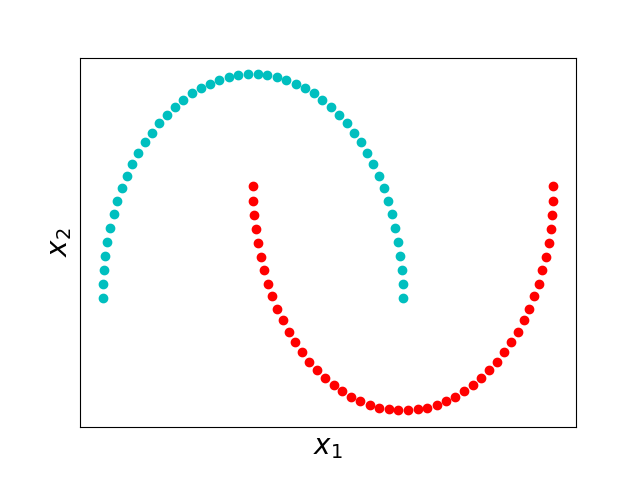

In [28]:
from sklearn.datasets import make_moons

X,y = make_moons(100)
model = DBSCAN()
preds = model.fit_predict(X)
# Either low or high values are good since DBSCAN might switch class labels.
print(f"Accuracy: {round((sum(preds == y)/len(preds))*100,2)}%")

fig= plt.figure(facecolor='w')
ax = plt.axes()
plt.plot(X[:, 0][preds==1], X[:, 1][preds==1], "co")
plt.plot(X[:, 0][preds==0], X[:, 1][preds==0], "ro")

# X contains two features, x1 and x2
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20)

# Simplifying the plot by removing the axis scales.
plt.xticks([])
plt.yticks([])

# Displaying the plot.
plt.show()

### 3D Radarsensor Experiment mit DBScan <a name="p44"></a>

In diesem Experiment sollen ein oder mehrere Ziele in einem drei dimensionalen Raum getrackt werden. Dafür werden der DBSCAN, zur Zielerkennung und der Kalman-Filter zur Laufbahnvorhersage genutzt.

In dem folgenden Code werden diese Ziele und ihre Laufbahnen angelegt:

In [29]:
# Parameters first target.
path1 = [[0,5,0],
         [0,5,0.5],
         [1,4,1],
         [2,3,2],
         [1,5,3],
         [1,5,0.5],
         [0.5, 2, 0.1]]

vel1 = 3 * np.ones((1,len(path1)))
vel1[0,2] = 1

InitialPosition1 = np.array([-1,5,0])

opt1 = {
    'InitialPosition' : InitialPosition1,
    'Path' : np.array(path1).transpose(),
    'Velocities' : vel1
}

# Parameters second target.
path2 = [[1. , 4. , 1. ],
         [1. , 5. , 1.7],
         [2. , 5. , 1. ],
         [3. , 4. , 2. ],
         [3. , 4. , 1.5],
         [2. , 4. , 2. ]]

vel2 = 2 * np.ones((1,len(path2)))
vel2[0,4] = 0.5

InitialPosition2 = np.array([2,4,1])

opt2 = {
    'InitialPosition' : InitialPosition2,
    'Path' : np.array(path2).transpose(),
    'Velocities' : vel2
}

Zusätzlich wird der Radar Sensor initialisiert:

In [30]:
'''
Setup the radar sensor
The radar sensor points always to the direction along the y axis
(see diagram in the note)
'''

optRadar = {
    'Position' : np.array([0,0,0.5]),
    'OpeningAngle' : np.array([120,90]), # [Horizontal, Vertical]
    'FalseDetection': True
}
sensor = RadarSensor(optRadar)

Die Bewegung der Ziele findet in einer while-Schleife statt. Dabei wird in jeder Iteration jedes Ziel einen Schritt weiter bewegt. Nachdem ein Schritt durchgeführt wurde versucht der Sensor die Ziele wahrzunehmen und mithilfe des DBSCAN die Ziele zu finden. Die Analyse durch den DBSCAN gibt allerdings erst ab einer in `pt_history` festegelegt Anzahl an Datenpunkten einen Sinn.\
Sobald das erste mal diese Anzahl erreicht wurde wird der DBSCAN in jeder Iteration auf die letzten `pt_history` Datenpunkte angewendet. Die dabei gefundenen Cluster werden den verschiedenen Zielen aus `labeled` zugeordnet. Exisitiert das Ziel noch nicht in diesem Dictionary wird es erstellt.

In [31]:
def scan(model, pt_history, targets):
    getNext = True
    detections = np.array([0,0,0,0])
    # Count number of iterations
    i = 0
    labeled = {}

    while(getNext == True):
        i += 1
        for target in targets:
            target.Step(1/sensor.opt['MeasurementRate'])
            getNext = getNext & ~target.reachedEnd  

        dets = sensor.Detect(targets)
        for det in dets:
            detections = np.vstack((det, detections))

        if i >= pt_history:
            # First application of DBSCAN.
            clusters = model.fit_predict(detections[:pt_history])
            # Determine number of targets (objects tracked).
            num_objs = set(clusters)

            for j in num_objs:
                # find index of first occurence of target j in clusters. This line is needed to filter out false detections
                obj_idx = np.where(clusters == j)[0][0]
                try:
                    last_obj_idx = np.where(clusters == j)[0][1]
                except:
                    last_obj_idx = -1

                if j not in labeled.keys():
                    labeled[j] = [detections[obj_idx]]
                else:
                    # try to check if label swap occured + correct it
                    # check if last detection is in the cluster if its not an outlier and we had enough found clusters (last_obj_idx)
                    if (not detections[last_obj_idx] in labeled[j]) and (last_obj_idx != -1):
                        for l in labeled.keys():
                            if detections[last_obj_idx] in labeled[l]:
                                j = l
                                break
                            

                s = detections[obj_idx]
                labeled[j] = np.vstack((s, labeled[j]))
                
    return labeled

In einigen Fällen, beispielsweise wenn ein neues Target in dem Sichtbereich des Sensors fliegt kann es zu einem "label swap" innerhalb des DBSCAN kommen. Dieser entsteht dadurch, das der DBSCAN dem ersten Cluster das er findet die id 1 gibt. Wenn nun ein neues Objekt in den Sichtbereich kommt bekommt dieses automatisch die id 1, anstatt der id 2 die in diesem Falle besser wäre (da es ein neues Cluster ist). Um diese Problematik abzufangen existiert der folgende Code innerhalb der while schleife:

``` python
if j not in labeled.keys():
    labeled[j] = [detections[obj_idx]]
else:
    # try to check if label swap occured + correct it
    # check if last detection is in the cluster if its not an outlier and we had enough found clusters (last_obj_idx)
    if (not detections[last_obj_idx] in labeled[j]) and (last_obj_idx != -1):
        for l in labeled.keys():
            if detections[last_obj_idx] in labeled[l]:
                j = l
                break
```

In diesem wird überprüft, zu welchem Cluster der letzte Punkt (nicht der der jetzt klassifiziert wird) gehört. Befindet er sich im gleichen Cluster ist alles gut, befindet er sich in einem anderen wird das label des zu klassifizierenden Punktes angepasst!\
Dadurch werden alle Datenpunkte dem jeweils richtigen Cluster zugeordnet.

Sobald die Datenpunkte visualisiert werden kann man erkennen, dass einige Datenpunkte Ausreißer sind und der Rest Pfade verschiedener Objekte darstellen. Über das folgende Dictionary wird festgelegt welches Objekt welche Farbe bekommen soll (Es sind so viele, denn je nach Einstellung der Parameter werden mehr als die zwei Realen Objekte gefunden).

In [32]:
colors = { -1: 'red', 0: 'green', 1: 'yellow', 2: 'blue', 3: 'purple', 4: 'orange', 5: 'pink', 6: 'black', 7: 'brown' }

Um eine gute Einstellung für den DBSCAN zu finden werden zuerst zwei Extreme Einstellungen getestet. Bei der ersten (links) Einstellungen werden die Parameter niedrig und bei der zweiten Einstellung (rechts) hoch initialisiert. Dabei wird die Variable `pt_history` bei einem Wert von konstant 20 belassen (ein Erhöhen dieser Variable entspricht einem Verringern von `minpts` und ein Verringern der Variable entspricht einer Erhöhung von `minpts` (das kann im interaktiven Beispiel am Ende der Sektion überprüft werden)).

Found 7 clusters and 406 outlier!
Found 2 clusters and 123 outlier!


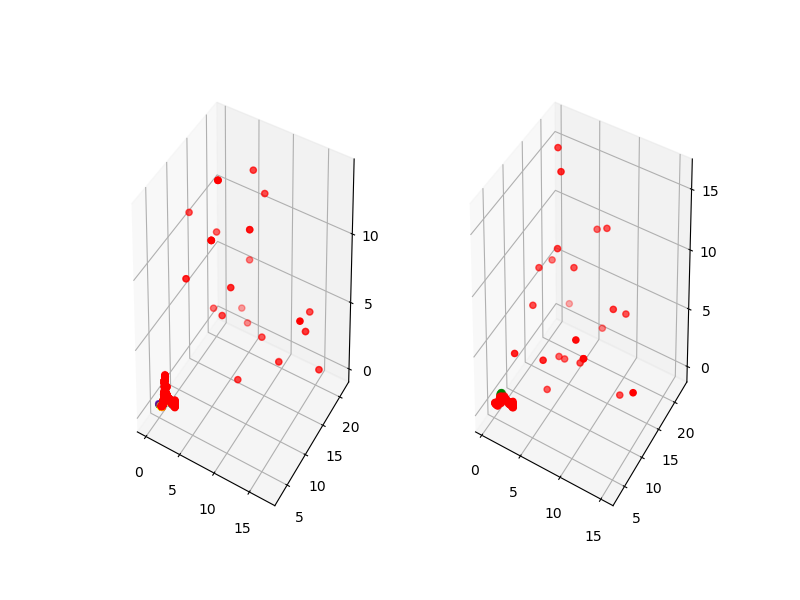

In [33]:
model1 = DBSCAN(eps=0.1, minpts=2)
model2 = DBSCAN(eps=1, minpts=10)
# Number of previous measurements to consider for DBSCAN().
pt_history = 20

# Instantiate targets
x = Target(opt1)
y = Target(opt2)

targets = [x, y]

# Plot Trajectories
fig= plt.figure(figsize=(8,6), dpi= 100, facecolor='w')
labeled1 = scan(model1, pt_history, targets)
print(f'Found {len(labeled1.keys())-1} clusters and {len(labeled1[-1])} outlier!')

ax = fig.add_subplot(1, 2, 1, projection='3d')
for label in labeled1.keys():
    T = labeled1[label];
    ax.scatter(T[:,0], T[:,1], T[:,2], c=f'{colors[label]}')   
    
    
# Instantiate targets
x = Target(opt1)
y = Target(opt2)

targets = [x, y]

labeled2 = scan(model2, pt_history, targets)
print(f'Found {len(labeled2.keys())-1} clusters and {len(labeled2[-1])} outlier!')

# Plot Trajectories
ax = fig.add_subplot(1, 2, 2, projection='3d')
for label in labeled2.keys():
    T = labeled2[label];
    ax.scatter(T[:,0], T[:,1], T[:,2], c=f'{colors[label]}')   

# show plot
plt.style.use('classic')
plt.show()

Das Ergebnis dieses Tests ist, das bei beiden Einstellungen etwas nicht stimmt. Bei der ersten zu niedrigen Einstellung werden zu viele Cluster gefunden. Das liegt vermutlich an einem zu niedrigen Wert für `eps`, denn dadurch werden nur die Punkte mit einer so geringen Entfernung einem Cluster zu geordnet => `eps` erhöhen. Ähnliches passiert bei der zweiten Einstellung. Bei dieser kann zwar Objekte in einem größeren Umkreis finden (was auch passiert), aber er braucht deutlich mehr `minPts` bevor diese zu einem Cluster zählen => `minPts` verringern. 

Ergebend aus unseren ersten beiden Tests ergibt sich das ein für uns gutes Ergebnis zwischen den beiden Extrema liegen muss. Also `eps` hoch und `minPts` runter (bei der Einstellung von `pt_history` = 20). Durch mehrere Tests der selben Art hat sich die folgende Einstellung für uns als gut ergeben.

Found 2 clusters and 107 outlier!


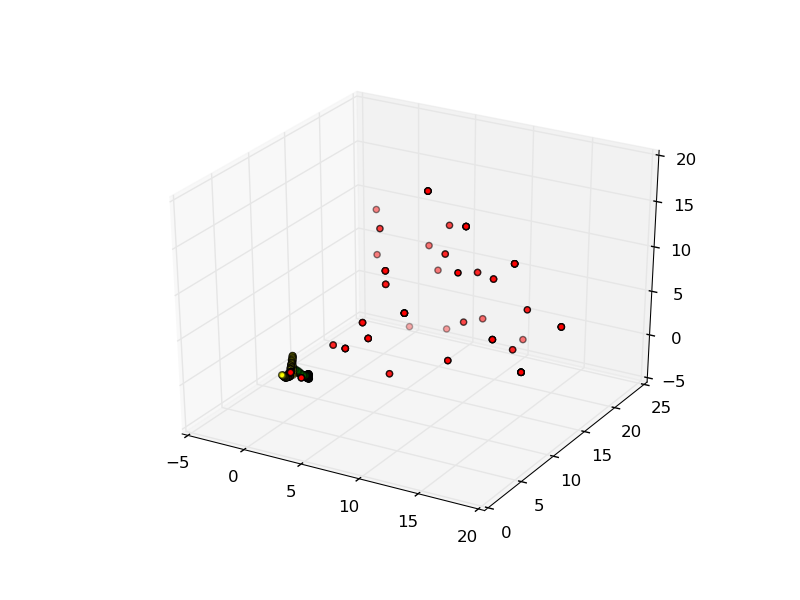

In [34]:
model = DBSCAN(eps=0.7, minpts=2)
# Number of previous measurements to consider for DBSCAN().
pt_history = 20

# Instantiate targets
x = Target(opt1)
y = Target(opt2)

targets = [x, y]

labeled = scan(model, pt_history, targets)
print(f'Found {len(labeled.keys())-1} clusters and {len(labeled[-1])} outlier!')

# Plot Trajectories
fig= plt.figure(figsize=(8,6), dpi= 100, facecolor='w')
ax = plt.axes(projection='3d')   
for label in labeled.keys():
    T = labeled[label]
    ax.scatter(T[:,0], T[:,1], T[:,2], c=f'{colors[label]}')   

# show plot
plt.show()

Wie zu sehen werden die beiden Objekte gut durch den DBSCAN erkannt und die Ausreißer erfolgreich rausgefiltert.

Zusätzlich wird noch überprüft, wie sich der Scan verhält, wenn ein neues Target zu einem späteren Zeitpunkt erscheint. Dafür befindet sich das Objekt zuerst außerhalb der Sicht des Sensors und fliegt dann hinein.

Found 2 clusters and 137 outlier!


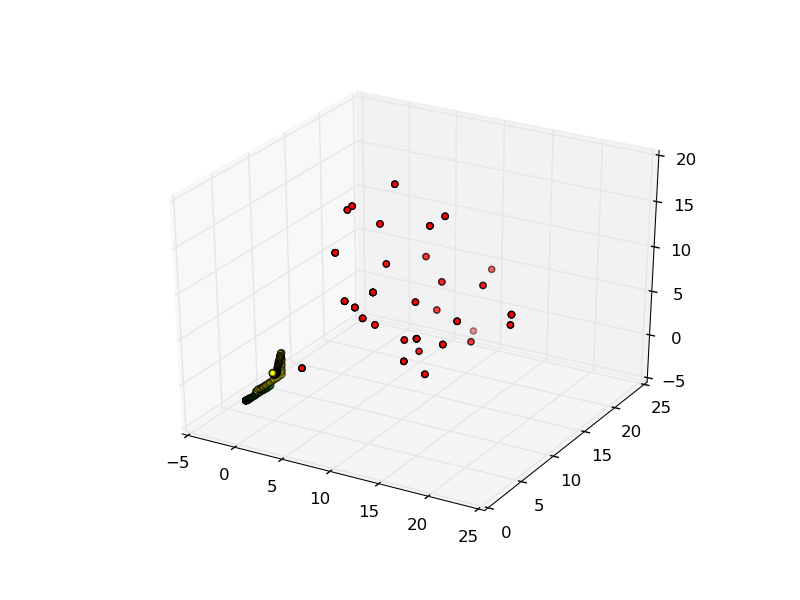

In [35]:
# Parameters first target.
path1 = [[0,5,0],
         [0,5,0.5],
         [1,4,1],
         [2,3,2],
         [1,5,3],
         [1,5,0.5],
         [0.5, 2, 0.1]]

vel1 = 3 * np.ones((1,len(path1)))
vel1[0,2] = 1

InitialPosition1 = np.array([-1,5,0])

opt1 = {
    'InitialPosition' : InitialPosition1,
    'Path' : np.array(path1).transpose(),
    'Velocities' : vel1
}

# Parameters second target.
path2 = [[-5. , -5. , -5. ],
         [-5. , -4. , -5. ],
         [-2. , -3. , -1. ],
         [-1. , -4. , -2. ],
         [1. , 2. , 1.5],
         [1. , 2. , 2. ]]

vel2 = 2 * np.ones((1,len(path2)))
vel2[0,4] = 0.5

InitialPosition2 = np.array([2,4,1])

opt2 = {
    'InitialPosition' : InitialPosition2,
    'Path' : np.array(path2).transpose(),
    'Velocities' : vel2
}

'''
Setup the radar sensor
The radar sensor points always to the direction along the y axis
(see diagram in the note)
'''

optRadar = {
    'Position' : np.array([0,0,0.5]),
    'OpeningAngle' : np.array([120,90]), # [Horizontal, Vertical]
    'FalseDetection': True
}
sensor = RadarSensor(optRadar)

model = DBSCAN(eps=1.5, minpts=2)
# Number of previous measurements to consider for DBSCAN().
pt_history = 20

# Instantiate targets
x = Target(opt1)
y = Target(opt2)

targets = [x, y]

# labeled, detections = scan(model, pt_history, targets)
labeled = scan(model, pt_history, targets)
print(f'Found {len(labeled.keys())-1} clusters and {len(labeled[-1])} outlier!')

# Plot Trajectories
fig= plt.figure(figsize=(8,6), dpi= 100, facecolor='w')
ax = plt.axes(projection='3d')
for label in labeled.keys():
    T = labeled[label]
    ax.scatter(T[:,0], T[:,1], T[:,2], c=f'{colors[label]}')

# show plot
plt.show()

Wie man sehen kann verhält sich der Scan wie zu erwarten und klassifiziert das neue Objekt unabhängig des ersten Objekts. Dadurch ist auch zusehen, dass der "label swap" verhindert wurde.

Die Ergebnisse des DBSCAN können jetzt mit dem KalmanFilter verbunden werden um größere Messfehler auszugleichen. Dafür wird für jedes Cluster ein neuer Filter angelegt, und zusätzlich zu den so gefundenen Datenpunkten, Vorhersagen angelegt. Die liste detections enthält dabei für jedes cluster eine Liste mit Sensormessungen der dazugehörigen Objekte. Die Radialgeschwindigkeit (letzter Eintrag der Messung) wird dabei nur für das clustern benötigt und somit nicht an den Filter weitergegeben. Das ganze funktioniert über die folgenden Zeilen:

``` python
s0 = np.vstack((detections[obj_idx,:-1], np.zeros((2,3))))
filters[j] = KalmanFilter(s0, transition_model, H, Q, R)
predictions[j] = [s0[0,:]]
```

Zusätzlich zur initialen Vorhersage werden mit den folgenden Zeilen nach jedem Schritt neue Punkte vorhergesagt:

``` python
s = filters[j].step(detections[obj_idx,:-1])
predictions[j] = np.vstack((s[0,:], predictions[j]))
```

In [36]:
# Use DBSCAN to track the paths and Kalman to correct the measurment errors
def scan_with_filter(model, pt_history, targets, R, Q, transition_model, H):
    getNext = True
    detections = np.array([0,0,0,0])
    # Count number of iterations
    i = 0
    labeled = {}
    predictions = {}
    filters = {}

    while(getNext == True):
        i += 1
        for target in targets:
            target.Step(1/sensor.opt['MeasurementRate'])
            getNext = getNext & ~target.reachedEnd  

        dets = sensor.Detect(targets)
        for det in dets:
            detections = np.vstack((det, detections))

        if i >= pt_history:
            # First application of DBSCAN.
            clusters = model.fit_predict(detections[:pt_history])
            # Determine number of targets (objects tracked).
            num_objs = set(clusters)

            for j in num_objs:
                # find index of first occurence of target j in clusters. This line is needed to filter out false detections
                obj_idx = np.where(clusters == j)[0][0]
                try:
                    last_obj_idx = np.where(clusters == j)[0][1]
                except:
                    last_obj_idx = -1

                if j not in labeled.keys():
                    labeled[j] = detections[obj_idx]
                    s0 = np.vstack((detections[obj_idx,:-1], np.zeros((2,3))))
                    filters[j] = KalmanFilter(s0, transition_model, H, Q, R)
                    predictions[j] = [s0[0,:]]
                else:
                    # try to check if label swap occured + correct it
                    # check if last detection is in the cluster if its not an outlier and we had enough found clusters (last_obj_idx)
                    if (not detections[last_obj_idx] in labeled[j]) and (last_obj_idx != -1):
                        for l in labeled.keys():
                            if detections[last_obj_idx] in labeled[l]:
                                j = l
                                break
                            

                s = filters[j].step(detections[obj_idx,:-1])
                predictions[j] = np.vstack((s[0,:], predictions[j]))
                labeled[j] = np.vstack((detections[obj_idx], labeled[j]))
                
    return predictions

Scan und Filter werden jetzt auf zwei Targets angewendet:

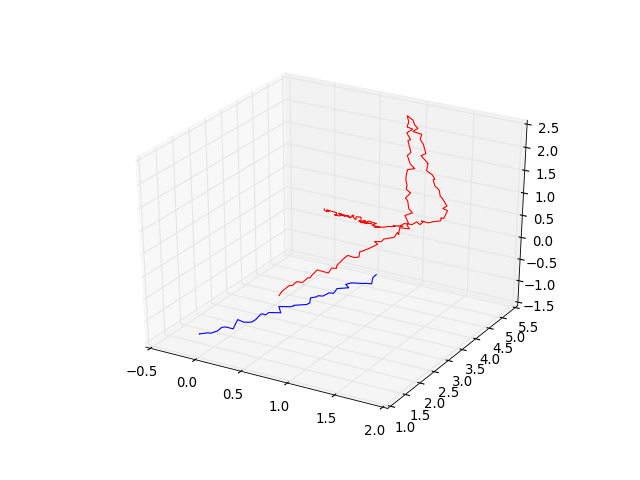

In [37]:
# Instantiate targets
x = Target(opt1)
y = Target(opt2)

targets = [x, y]

# Measurement error.
## Variance of a uniform distribution is given by (b-a)**2/12.
R = np.diag([rangeAccuracy**2])/3
# Process error.
Q = np.diag([0.05,0.05,0.05])
# Process/transition model.
transition_model = np.array([[1, 0.01, 0.01/2],
                             [0, 1, 0.01],
                             [0, 0, 0.01]])
# Transformation matrix
## Transforms predicted quantities into outputs that can be compared to the measurements
H =  np.array([[1., 0., 0.]])


getNext = True
Detections = np.array([0,0,0])
model = DBSCAN(eps=0.7, minpts=2)
# Number of previous measurements to consider for DBSCAN().
ante = 20

Preds = scan_with_filter(model, ante, targets, R, Q, transition_model, H)
         
# Visualize trajectory.
T1 = Preds[0]
T2 = Preds[1]

# Plot Trajectory
fig = plt.figure(facecolor='w')
ax = plt.axes(projection='3d')   
#ax.view_init(20, 35) 
ax.plot3D(T1[:,0], T1[:,1], T1[:,2], 'blue')   
ax.plot3D(T2[:,0], T2[:,1], T2[:,2], 'red')    

# show plot
plt.show()

Im Ergebnis ist zu sehen das der DBSCAN und der Kalman Filter die Objekte erfolgreich tracken können.

## Interaktiver Teil (Jupyter Notebook) <a name="p5"></a>

*Um diesen Teil nutzen zu können, muss das Jupyter Notebook im Browser ausgeführt werden*

### Interaktives Kalman Filter 1D <a name="p51"></a>

Im interaktiven Kalman Filter 1D können sämtliche Parameter des 1D Experiments angepasst werden und dadurch die unterschiedlichen Auswirkungen auf das Ergebnis beobachtet werden.

Output()

Output()

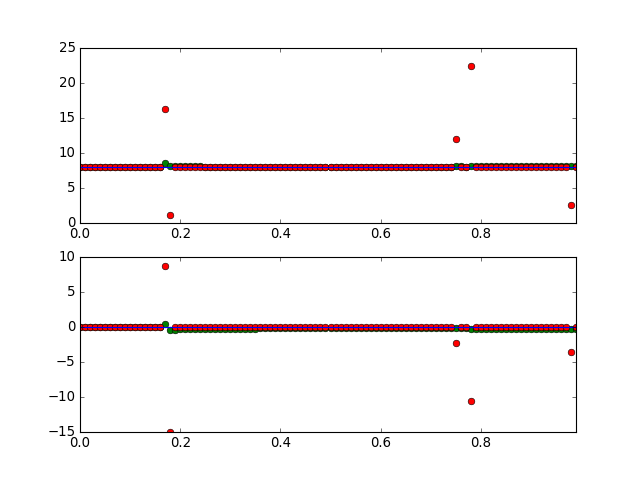

In [38]:
interactive1DExperiment.plot_interactive_kalaman_filter()

### Interaktiver DBScan <a name="p52"></a>

In dem folgenden Beispiel können die Parameter `eps`,`minPts` und `PT History` verstellt werden, um zu sehen, wie die verschiedenen Einstellungen das Ergebnis des DBScan beinflussen.

Output()

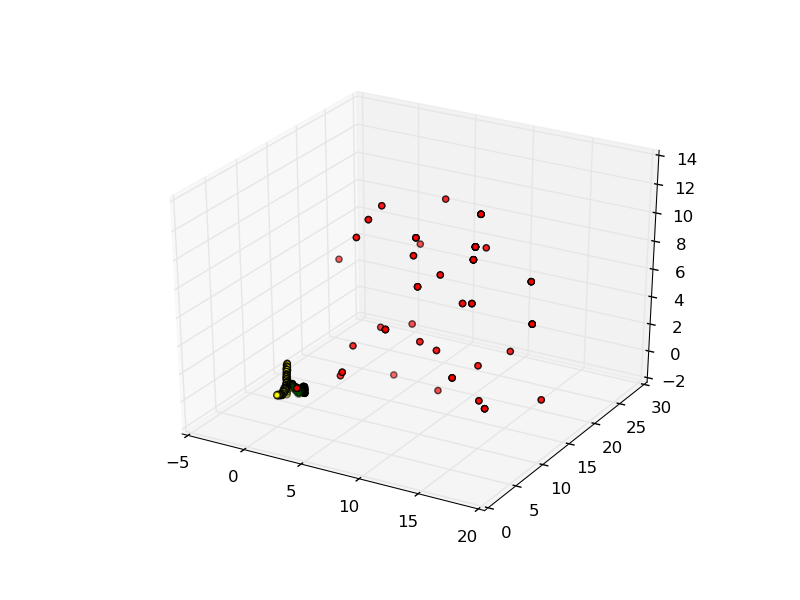

In [39]:
interactiveDBScan.plot_interactive_dbscan()

### Interaktiver Kalman Filter mit DBScan 3D <a name="p53"></a>

Im interaktiven Kalman Filter 3D können die Parameter des DBScan angepasst werden und dadurch die unterschiedlichen Auswirkungen auf das Ergebnis beobachtet werden. Zusätzlich können bis zu vier *Targets* gleichzeitg ausgewählt werden und für einzelne *Targets* können auch die *False Detections* angezeigt werden.
Der rote Punkt zeigt die Position des Radarsensors an.

Output()

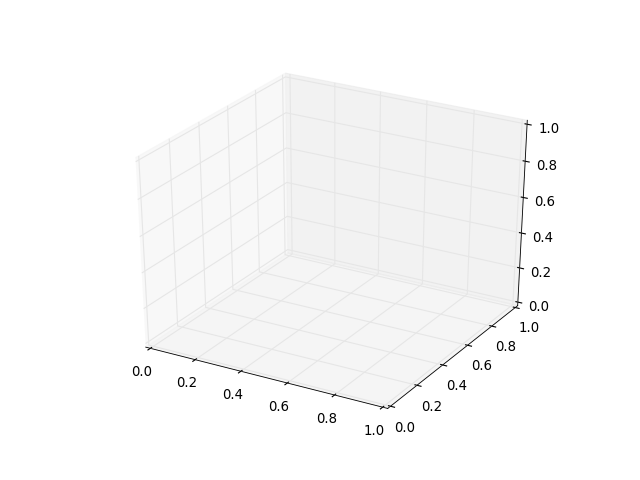

In [40]:
interactive3DExperiment.plot_3DExperiment()

## Schlussfolgerung und Ausblick <a name="p6"></a>

TEXT EINFÜGEN

## Verwendete Literatur <a name="p7"></a>

1. Kalman and Bayesian Filters in Python, 2015, Roger R. Labbe

## Anhang <a name="p8"></a>

## GitHub Workflow <a name="p81"></a>

Um den Code für unser Projekt zu verwalten haben wir ein privates GitHub Repository verwendet. Sofern die Berechtigung im Voraus erteilt wurde, ist das Repository unter folgendem Link erreichbar: https://github.com/otiofrui/pml

## Jupyter Notebook <a name="p82"></a>

Da sowohl das Kalman Filter, als auch der DBScan und die Radarsensor Simulation viele Einstellungsmöglichkeiten bieten, haben wir uns dafür entschieden unseren Bericht mit Hilfe eines Juypter Notebooks interaktiv zu gestalten. Dies ermöglicht es dem Leser die Parameter der Programme selbst anzupassen und das Ergbenis so zu beinflussen.